# Thematic Mapping Switzerland

In this notebook, I try to **port to Python a very clever and inspiring mapping technique that [Timo Grossenbacher](https://timogrossenbacher.ch/) and [Benja Zehr](https://benjazehr.ch/) have created in R.** 

**Please have a look at their blog posts [here](https://timogrossenbacher.ch/2016/12/beautiful-thematic-maps-with-ggplot2-only/) and [here](https://timogrossenbacher.ch/2019/04/bivariate-maps-with-ggplot2-and-sf/) where they describe all the thinking and work behind it.**

> ⚠️ **All the credit for this beautiful mapping technique belongs entirely to Timo and Benja.** 

I was curious how hard it would be to port their project to Python and wanted to make their approach available for Python users. I was also interested in how close one can get with Python's plotting tools (namely Matplotlib) to the ggplot2 result. I merely ported the code and kept close to Timo's and Benja's settings. 

**What did I find out?**

- It goes without saying: Python's geo data and graphing tooling work differently than R's. A simple 1:1 conversion of the code wasn't feasible. Nonetheless, many of the author's steps could be applied in this version too. 
- Visually the result comes quite close to the original (at least in my perspective).
- Controlling a map layout with all elements pixelperfect is not an easy task in matplotlib. This seems somewhat easier in R/ggplot. 
- A versatile GIS tool was an absolute must to explore the geo data sets efficiently and find the right shapes. [QGIS](https://www.qgis.org/en/site/) (which I used) was very helpful in order to browse and understand the various layers of the awesome and detailed geo data offerings of the [Federal Statistical Office BFS](https://www.bfs.admin.ch/bfs/en/home/statistics/regional-statistics/base-maps/cartographic-bases.html) and [Federal Office of Topography swisstopo](https://www.swisstopo.admin.ch/en/geodata/maps.html). 
- It was **more difficult than I expected to find a proper workflow in Python to mask raster maps with vector shapes**. One can either mask the layer with QGIS ([see second notebook in repo](02_Mask-Raster-With-QGIS.ipynb)) or cut out the shape with [gdal](https://gdal.org/)'s Python bindings directly in the noteebook (see below).

<div class="alert alert-info" style="font-size:100%">

**⚠️ Important note**

- To work with this notebook you need to download three data sets. 
- **You need to check the terms of usage for the data on the respective sites – see links below – and use the data accordingly.** 
- This notebook is created **purely for educational purposes** and comes **without any licenses for the data.** 

</div>

## Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use('ggplot')

import pandas as pd
import numpy as np

import os
import shutil
import requests

import geopandas as gpd
import mapclassify
import rasterio
from rasterio.plot import show

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

## Set Defaults

In [2]:
BG_COLOR = "#f4f4f4"
FIG_SIZE = (16, 10)
TITLE_SIZE = 24

params = {
    'text.color': (0.30, 0.30, 0.30),
    'figure.figsize': FIG_SIZE,
    'figure.edgecolor': BG_COLOR,
    'figure.facecolor': BG_COLOR,
    'axes.edgecolor': BG_COLOR,
    'axes.facecolor': BG_COLOR,
    'axes.grid': False,
   }

plt.rcParams.update(params)

In [3]:
# prepare a visually more pleasing magma colormap with less extreme values
# this step is taken from Timo's and Benja's blog post
colors = [plt.cm.magma(x) for x in np.linspace(0, 1, num=8)[1:-1]]
magma_fix = ListedColormap(colors, name="magma_fix").reversed()

## Get data from sources

- [Kartengeometrien ThemaKart Set](https://www.bfs.admin.ch/bfs/de/home/statistiken/regionalstatistik/kartengrundlagen/basisgeometrien.assetdetail.15784603.html) – This set contains all necessary **shapefiles** (and much more if you want to vary the application).
- [Swiss Map Vector 1000](https://www.swisstopo.admin.ch/de/geodata/maps/smv/smv1000.html) – A comprehensive set of Swiss vector maps (again – very worth exploring). The set contains the (unprocessed) **relief raster maps** as well.
- [Wohnbevölkerung nach institutionellen Gliederungen](https://www.pxweb.bfs.admin.ch/pxweb/de/px-x-0103030000_102/-/px-x-0103030000_102.px) - The **demographic data** from which we will calculate the mean age per municipality («Politische Gemeinde»).

**The terms of usage and licensing for all data sets are defined by the BFS and swisstopo and have to be clarified for your use case by you.**

In [4]:
url_themakart = "https://dam-api.bfs.admin.ch/hub/api/dam/assets/15784603/master"
url_swissmapvector = "https://data.geo.admin.ch/ch.swisstopo.swiss-map-vector1000.metadata/SMV1000_SHAPE_CHLV95.zip"
url_demographic = "https://www.pxweb.bfs.admin.ch/sq/a5f89613-30c0-4633-b293-6b7effdb366a"

In [5]:
# please be patient, downloading the data may take a while (~30 to ~60 secs)

# check if data folder exists and data is downloaded already
# if not – download again and unpack...

if not os.path.isdir('_downloads/'):
    os.mkdir("_downloads/")

if not os.path.isfile('_downloads/alter_nach_gemeinden.csv'):
    res = requests.get(url_demographic)
    with open("_downloads/alter_nach_gemeinden.csv", "w") as file:
        file.write(res.text)
        
file_name_tk = "_downloads/geo_themakart.zip"
if not os.path.isdir('_downloads/2021_GEOM_TK'):
    res = requests.get(url_themakart)

    with open(file_name_tk, "wb") as file:
            file.write(res.content)
    shutil.unpack_archive(file_name_tk, "_downloads/")
    
file_name_sm = "_downloads/geo_swissmapvector.zip"    
if not os.path.isdir("_downloads/20161001_SMV1000_SHAPE_CHLV95/"):
    res = requests.get(url_swissmapvector)

    with open(file_name_sm, "wb") as file:
            file.write(res.content)
    shutil.unpack_archive(file_name_sm, "_downloads/")

# cleaning up
if os.path.isfile(file_name_tk):
    os.remove("_downloads/geo_themakart.zip")
if os.path.isfile(file_name_sm):
    os.remove("_downloads/geo_swissmapvector.zip")   

print("All data sets are downloaded and unpacked.")

All data sets are downloaded and unpacked.


## Load Data

In [6]:
# this layer with geo shapes for the municipalities is the crucial layer for the cloropleth map
mun = gpd.read_file("_downloads/2021_GEOM_TK/GEOM_2021/01_INST/Vegetationsfläche_vf/K4_polg20210101_vf/K4polg20210101vf_ch2007Poly.shp")
mun.id = mun.id.astype(int)
# set geo data from epsg:21781 to epsg:2056 
mun = mun.to_crs("epsg:2056")

# load additional shapes: Cantons, lakes, and raster lines
cnt = gpd.read_file("_downloads/2021_GEOM_TK/GEOM_2021/01_INST/Vegetationsfläche_vf/K4_kant19970101_vf/K4kant19970101vf_ch2007Poly.shp")
lakes = gpd.read_file("_downloads/2021_GEOM_TK/GEOM_2021/00_TOPO/K4_seenyyyymmdd/k4seenyyyymmdd11_ch2007Poly.shp") 

# load coordinate lines for a subtle visual effect
lines = gpd.read_file("_downloads/20161001_SMV1000_SHAPE_CHLV95/Shapefiles/08_DKM1M_KOORDINATENNETZLINIE.shp")

df = pd.read_csv("_downloads/alter_nach_gemeinden.csv")

## Prepare relief layer

In [7]:
from osgeo import gdal
raster_file = f"_downloads/20161001_SMV1000_SHAPE_CHLV95/Shapefiles/25_RELI.tif"
shape_file = f"_downloads/2021_GEOM_TK/GEOM_2021/01_INST/Gesamtfläche_gf/K4_suis18480101_gf/K4suis18480101gf_ch2007Poly.shp"
shape_layer = "K4suis18480101gf_ch2007Poly"
out_file = "_input/ch_relief_bw.tif"


options = gdal.WarpOptions(dstAlpha=True, 
                           cropToCutline=True,
                           cutlineDSName=shape_file,
                           cutlineLayer=shape_layer,
                           multithread=True,
                           )

ds = gdal.Warp(out_file, raster_file, options=options)
del ds

# load the raster relief that we have created
relief = rasterio.open('_input/ch_relief_bw.tif')

## Prepare Data

In [8]:
# some cleaning and renaming to simplify the handling of the dataframe
cols = ["Jahr", "Alter - Total", "Bevölkerungstyp"]
df.drop(cols, axis=1, inplace=True)
df.rename({'Kanton (-) / Bezirk (>>) / Gemeinde (......)': "mun"}, axis=1, inplace=True)

# reduce to the municipal data samples
df = df[df.mun.str.startswith("......")]
df.mun = df.mun.apply(lambda x: x.replace("......", ""))

# extract the unique id for the municipality
df["id"] = df.mun.apply(lambda x: int(x.split()[0]))

# isolate names of municipalities
df.mun = df.mun.apply(lambda x: x[5:])

# since we only get counts in age groups we need to create a frequency table to properly calculate the mean

# get all age values
freqs = df.iloc[:, 1:-1].values
# sanity check that we calculate based on all ages from 0 to 100+ (101 total)
assert freqs.shape[1] == 101

# create frequency table
vals = list(range(len(freqs[0])))
df["age_mean"] = [np.mean(np.repeat(vals, x)) for x in freqs]

# reduce dataframe to names, codes and mean age
df = df.iloc[:, [-2, 0, -1]].reset_index(drop=True)

## Detour: the intricacies of the Swiss municipal system

If we compare the number of municipalities in the two data sets we observe a discrepancy: The geo data contains **2172** municipalities, the demographic data just lists **2163**. 

In [9]:
print(f"{mun.shape[0]} municipalities in geo data\n{df.shape[0]} municipalities in demographic data")

2172 municipalities in geo data
2163 municipalities in demographic data


**Why is that?**

- The geo data is as of **1.1.2021**
- The demographic data were counted as of 31.12.2021 based on a **spatial reference as of 1.7.2021**. See [footnotes here](https://www.pxweb.bfs.admin.ch/pxweb/de/px-x-0103030000_102/-/px-x-0103030000_102.px/).
- **Between 1.1. and 1.7.2021 several municipalities were mutated**, more specifically fused to larger ones:
   * Assens, Bioley-Orjulaz became the new municipality **Assens**
   * Croglio, Monteggio, Ponte Tresa, Sessa became the new municipality **Tresa**
   * Apples, Bussy-Chardonney, Cottens, Pampigny, Reverolle, Sévery became the new municipality **Hautemorges**
   
Mutations in the municipal registry are listed [here](https://www.bfs.admin.ch/asset/de/20604222). 

To get a more precise mapping we have to mutate our geo data as well. This is – thanks to [geopandas](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) – quite simple.

In [10]:
# fuse Assens, Bioley-Orjulaz to new municipality Assens (ID 5511)
new_assens = mun[mun.id.isin([5511, 5513])].dissolve().geometry[0]
# Assens already has a named entry that we simply overwrite with the new fused shape
mun.loc[mun.id==5511, "geometry"] = new_assens

# fuse Croglio, Monteggio, Ponte Tresa, Sessa to new municipality Tresa (ID 5239)
new_tresa = mun[mun.id.isin([5178, 5202, 5213, 5222])].dissolve().geometry[0]
tresa = gpd.GeoDataFrame(data=(5239, "Tresa", new_tresa)).T
tresa.columns = ["id", "name", "geometry"]
tresa = tresa.set_geometry("geometry")
tresa = tresa.set_crs(epsg=2056)
mun = pd.concat([mun, tresa])

# fuse Apples, Bussy-Chardonney, Cottens, Pampigny, Reverolle, Sévery to new municipality Hautemorges (ID 5656)
new_tresa = mun[mun.id.isin([5421, 5625, 5478, 5494, 5644, 5500])].dissolve().geometry[0]
hautemorges = gpd.GeoDataFrame(data=(5656, "Hautemorges", new_tresa)).T
hautemorges.columns = ["id", "name", "geometry"]
hautemorges = hautemorges.set_geometry("geometry")
hautemorges = hautemorges.set_crs(epsg=2056)
mun = pd.concat([mun, hautemorges])

# drop obsolete entries
obsolete = [5513, 5178, 5202, 5213, 5222, 5421, 5625, 5478, 5494, 5644, 5500]
mun.drop(mun[mun.id.isin(obsolete)].index, inplace=True)

mun.reset_index(drop=True, inplace=True)

In [11]:
# finally we merge the calculated demographic data with the GeoDataFrame
mun_age = pd.merge(mun, df, left_on="id", right_on="id", how="left")

## Plot Map

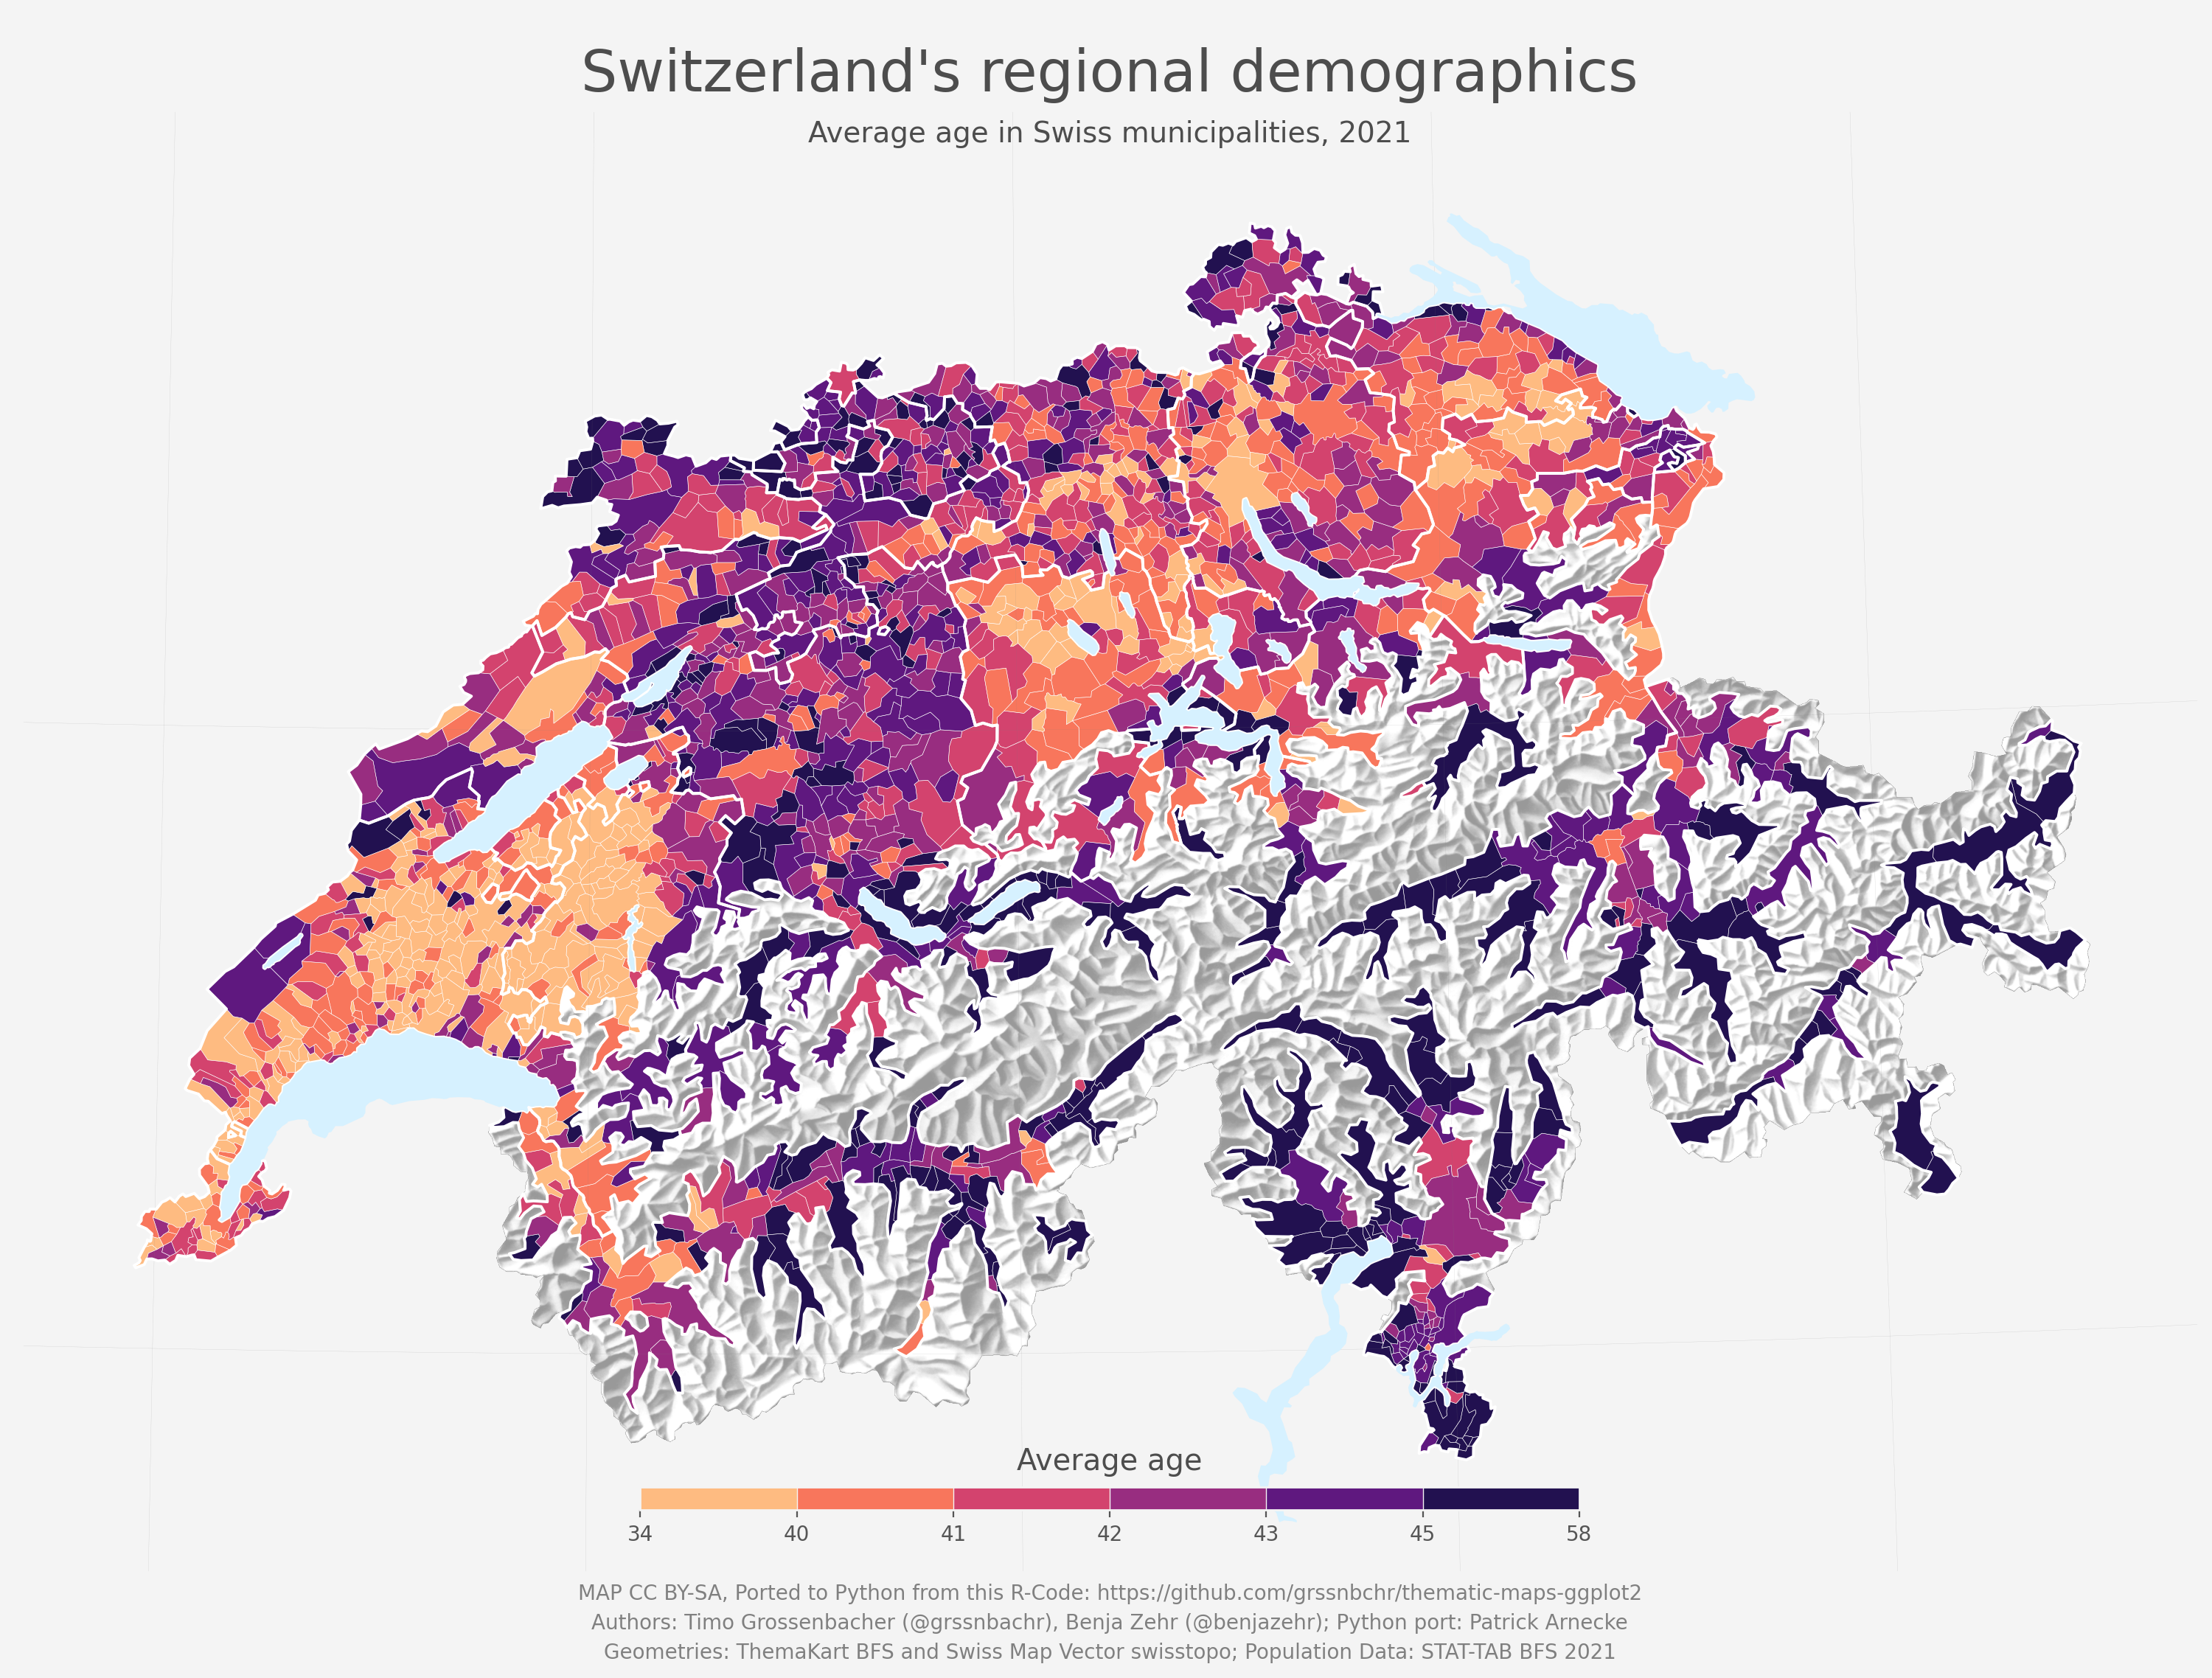

In [12]:
fig, ax = plt.subplots(constrained_layout=True)


# plot the text elements at the top
fig.text(0.5, 1.05, s=" ")
fig.suptitle("Switzerland's regional demographics", 
             y=1.02, size=28, ha="center", va="center")
fig.text(0.5, 0.98, s="Average age in Swiss municipalities, 2021", 
         size=14, ha="center", va="center")


# plot the text elements at the bottom
fontdict = {"size":10, "ha": "center", "va": "center", "color": "grey"}
fig.text(0.5, -.01, s="MAP CC BY-SA, Ported to Python from this R-Code: https://github.com/grssnbchr/thematic-maps-ggplot2", fontdict=fontdict)
fig.text(0.5, -.03, s="Authors: Timo Grossenbacher (@grssnbachr), Benja Zehr (@benjazehr); Python port: Patrick Arnecke", fontdict=fontdict)
fig.text(0.5, -.05, s="Geometries: ThemaKart BFS and Swiss Map Vector swisstopo; Population Data: STAT-TAB BFS 2021", fontdict=fontdict)


# plot light raster lines for a subtle effect
lines.plot(color="grey", linewidth=.1, alpha=.4, ax=ax)

rasterio.plot.show(relief.read(), ax=ax, transform=relief.transform, zorder=1)


# cloropleth layer: the coloring is controlled by column "age_mean"
# the binning scheme is calculated by mapclassify with 'quantiles' as the algorithm and k=6 being the number of bins
mun_age.plot(column="age_mean", ax=ax, cmap=magma_fix, scheme="quantiles", k=6)


# plot municipal and cantonal borders
mun.boundary.plot(ax=ax, color="white", linewidth=.2, alpha=.8)
cnt.boundary.plot(ax=ax, color="white", linewidth=1.4)


# plot lakes
lakes.plot(ax=ax, color="#d6f1ff", zorder=2)


# recreate binning scheme 
qts = mapclassify.Quantiles(mun_age.age_mean, k=6)

# add colorbar based on binning scheme and custom magma map
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=magma_fix), 
                    aspect=40, 
                    shrink=.4, 
                    pad=-.08,
                    location="bottom",
                    orientation="horizontal",
                    ax=ax, 
                    drawedges=True
                    )


# set proper colorbar ticks and labels
bins = [int(mun_age.age_mean.min())]
bins.extend(qts.bins.astype(int))
cbar.set_ticks(np.linspace(0, 1, len(bins)))
cbar.set_ticklabels(bins)
cbar.ax.set_title('Average age', pad=8)


# get bounds of municipal base layer, set new x/y-limits with padding
pad = 2e4
xmin, ymin, xmax, ymax = mun_age.total_bounds
ax.set_xlim(xmin-pad, xmax+pad)
ax.set_ylim(ymin-pad, ymax+pad)


# remove ticks
ax.set_xticks([])
ax.set_yticks([])

fig.show()

# save map to file
fig.savefig("_output/swiss_regional_demographics_2021.jpg", 
            bbox_inches="tight", 
            pad_inches=.1,
            dpi=120)

<sub>Patrick Arnecke, 2022 | Original authors of this technique: Timo Grossenbacher and Benja Zehr<sub>